# Resistor Network Code

8/16/24 

Code by Shardul Mukim

Annotatations and visualization code by Andrew Truttmann

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla
import pandas as pd

E0, E1, and E2 output a list of tuples. Each of these tuples represents an edge connecting 2 nodes, and this info is added to the 2D graph object. See attached image for how the node numbering system works. Note that as of right now, this code only works for a setup with a 4x4 flakes base. 



In [5]:
def E0(layers):                                        #layers here is a horiz. dimension, it is 4 in our experiments
    m1=[]
    for j in np.arange(0,8*layers,8):
        m1.append([(i+j,i+1+j) for i in range(7)])
    return np.array(m1).reshape(-1,2)
def E1(layers):
    m2=[]
    for j in np.arange(0,8*(layers-1),8):
        m2.append(np.array([((j+i,j+7+i),(j+i,j+7+2+i)) for i in np.arange(1,7,2)]))
    m2=np.array(m2).reshape(-1,2)
    return m2
def E2(layers):
    m3=[]
    m3.append([(j+7,j+14) for j in np.arange(0,8*(layers-1),8)])
    m3=np.array(m3).reshape(-1,2)
    return m3

def create_graph(layers,seed):                
    np.random.seed(seed)
    G = ntx.Graph()
    e0 = E0(layers)
    e1 = E1(layers)
    e2 = E2(layers)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
    G.add_edges_from(e2)
    return G



#Shardul mentioned there might be a way to optimize by just giving graph an overall structure, but code works fine as is

Create_3d_graph stacks a bunch of unit cell 2d graphs on top of each other, and appropriately adds connections between them. In addition, it creates the external nodes that will be connected to every node in the uppermost or bottommost surfaces. This is so current isn't only injected at one point.

Important note: For IP, the external nodes only connect to half of the flakes on the left/right sides. Using the numbering system, this is 0,8,16,and 24 on the left, 7,15,23, and 31 on the right.

In [8]:
def create_3d_graph(layers, seed, depth, isOOP):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}        #dictionary: Map old node numberings into an array where its organized by (2Dgraph numbering, depth). For example: converts node 32 to (0,1) to denote first flake of second unit cell. 

    for z in range(depth):
        for node in G_2d.nodes:                           #total number of nodes in 2d graph is 8*layers
            G_3d.add_node(node_count)                      #depth is the number of unit cells stacked, each unit cell is composed of two 16 flake sections
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(node_mapping[(edge[0], z)], node_mapping[(edge[1], z)])

    # Connect layers vertically (with the correction). Odd flakes from current layer connect to even flakes in above layer.
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1:
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(node_mapping[(node, z)], node_mapping[(neighbor, z + 1)])
                    

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  #last node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  #last node_in_3d_graph + 2
    external_node_2 = node_count

    if(isOOP):   #if we're looking at the OOP configuration
        # Connect bottom layer even nodes to external_node_1
        for node in G_2d.nodes:
            if node % 2 == 0:
                G_3d.add_edge(node_mapping[(node, 0)], external_node_1)  # Bottom layer (z=0)
    
        # Connect top layer odd nodes to external_node_2
        for node in G_2d.nodes:
            if node % 2 == 1:
                G_3d.add_edge(node_mapping[(node, depth - 1)], external_node_2)  # Top layer (z=depth-1)


    else:   #IP configuration
        # Connect side layer even nodes to external_node_1
        for x in range(depth):
            for node in G_2d.nodes:
                if node % 8 == 0:
                    G_3d.add_edge(node_mapping[(node, x)], external_node_1)  #left side
    
        # Connect side layer odd nodes to external_node_2
        for x in range(depth):
            for node in G_2d.nodes:
                if node % 8 == 7 :
                    G_3d.add_edge(node_mapping[(node, x)], external_node_2)  #right side
        

    #test later
    return G_3d,external_node_1,external_node_2    #As an example, if depth=2, nodes 0-63 represent flakes in the bulk, 64 and 65 represent the external nodes

In [10]:
def generate_random_values(mean, std, seed, num_edges):        #simply generates random values to be used as contact resistances later
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))

Matrix_interactions creates a 3D graph object representing the system, and then does the necessary linear algebra. See Colin O'Callaghan's thesis section 2.1. It creates the Kirchoff/adjacency matrix, which satisfies the equation $K \vec{V} = \vec{I}$, where $V$ is the vector assigning a voltage to every node, and $I$ is the current vector (zero everywhere except at the external nodes where current is injected/drained. The net current therefore is zero through the complete circuit). Inverting this matrix then gives you a way to calculate voltage. (Note: technically $K$ is always non-invertible, there are some subtleties and approximations I don't understand and this might be worth investigating further). 

In this program, $K$, $V$, and $I$ are held by the arrays adjM, V_vec, and I_vec respectively. $K^{-1}$ is held by MI.

Creating the cap_values creates the distribution of resistances. This can be tweaked to see if low resistance "hotspots" have an effect, how the variation in a standard distribution of resistance matters, etc. Cap_values are inverted in interactions because the adjacency matrix takes conductance values not resistances. 

Arguments of matrix_interactions: $\textbf{Depth}$ is the vertical extent of the system, each depth has two 16 flake sections. $\textbf{Std}$  $\textbf{h_frac}$, and $\textbf{ext_R}$ are arguments accessed when the cap_values are created. They control the standard deviation, the fraction of flakes that are hotspots (should be between 0 and 1), and the resistances of the connections to the external nodes respectively. Keep in mind that the average resistance for a connection in the bulk is set to 1. $\textbf{isOOP}$ should be set to True for the OOP configuration, False for the IP. $\textbf{Seed}$ allows you to repeat the results of the pseudorandom number generator. $\textbf{Visuals}$ can be turned on or off depending if you want to visualize your results.


I've also added some code to calculate the magnitude of current flowing through each node to make a current heat map. For each node, each edge is summed over and the magnitude of current flow is added. Shardul fixed this for me by using this line instead: R_edge = (MI[i,i] + MI[j,j] - MI[i,j] - MI[j,i]). This calculates the resistance between two nodes, accounting for all possible paths through the network.

In [13]:
def matrix_interactions(depth, std,seed, isOOP, h_frac=0.0, ext_R = 0.0001,  visuals = False):    #defaults are seed=0, no hotspots, and external resistances are negligibly small

    grid,a,b = create_3d_graph(4, seed, depth, isOOP)        #a is number of external node 1, b is external node 2
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    np.random.seed(seed)
    
    h= int(h_frac * num_edges)
    
    cap_values = np.abs(1 * np.concatenate((generate_random_values(1, std, seed, num_edges-h),generate_random_values(0.0001, 0, seed, h))))      #hotspots
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values  #we're dividing since the kirchoff matrix elements are conductance not resistance
    
    adjM = sc.lil_matrix((nodes, nodes))
    xxx = list(grid.edges())                      
    
    for edge_idx, (i, j) in enumerate(xxx):
        if i == a or j == a or i == b or j == b:  # First handle external node connections
            adjM[i, j] = 1.0 / ext_R
            adjM[j, i] = 1.0 / ext_R  # External nodes get conductance based on ext_R
        elif i < a and j < a:  # Now handle internal node connections
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value  # Assign resistance value for internal nodes
            adjM[j, i] = interaction_value
 #assigning conductance for the external node connections. Assign a high value (low ext_R) to create an equipotential on the top layer
                                            #and match the theoretical model. Assign a value close to one to more closely match experiment.

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 -0.000001)     #The 0.000001 is an approximation to avoid a singular matrix and make taking the ivnerse possible
    
    
    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())
    
    if(visuals):
        #calculating the vector associated with voltage
        I_vec = np.zeros(MI.get_shape()[0])      #these three lines create the vector representing current. A current of 1 is in injected through the external nodes
        I_vec[a] = 1                            #all other entries are zero
        I_vec[b] = -1

        V_vec = np.array(MI.dot(I_vec))      #matrix multiplication, vector that gives the voltage at each node
        R_OOP = V_vec[a] - V_vec[b]            #V=IR, works since I=1
    
        
        #calculating current flowing through each node
        Iabs_vec = np.zeros(len(I_vec))
        
        for edge_idx, (i, j) in enumerate(xxx):
            R_edge = (MI[i,i] + MI[j,j] - MI[i,j] - MI[j,i])           #calculating the network resistance between those two points
            #R_edge = cap_values[edge_idx]                               #accessing resistance between nodes
            I_edge = (V_vec[i] - V_vec[j])/R_edge       #using I = V/R
            Iabs_vec[i] += np.abs(I_edge)               #abs because otherwise we'd get zero, current in = current out
            Iabs_vec[j] += np.abs(I_edge)               #this is necessary for each node to be counted the right num of times

        return R_OOP, V_vec, Iabs_vec
    
    else:
        return MI[a, a] + MI[b, b] - MI[a,b] - MI[b, a]   #does the same thing as the matrix multiplication
        

Here is an example of running the code for one calculation, and then displaying the results. Simply edit the arguments of the first line to calculate what you want.

Visuals:
First the current heat map is plotted in 3D to see the big picture. Second, 2D slices of the voltage and current maps are displayed for more clarity.

R_OOP =  0.12505321724711393


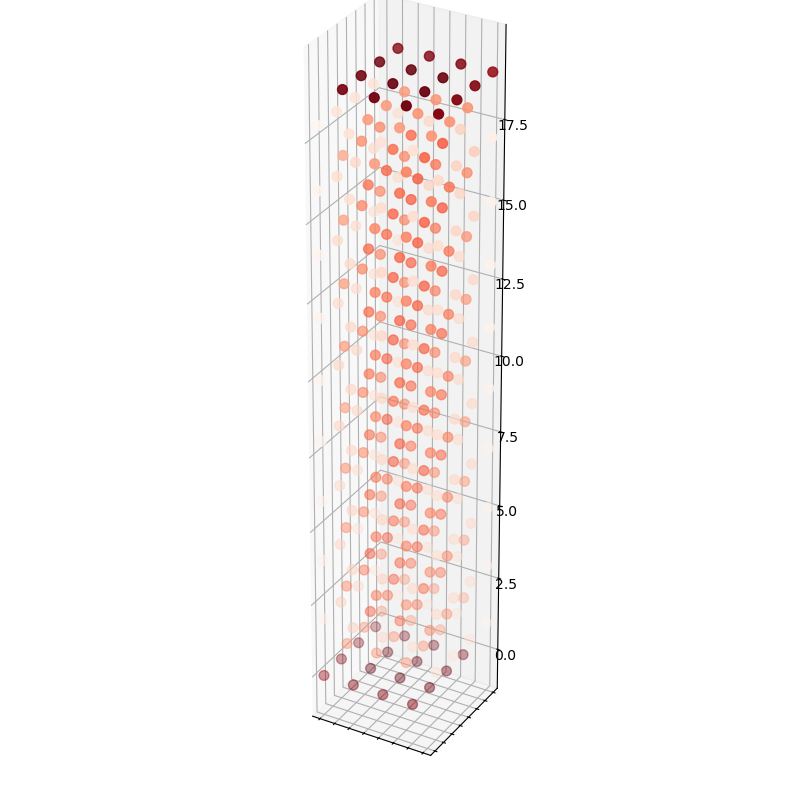

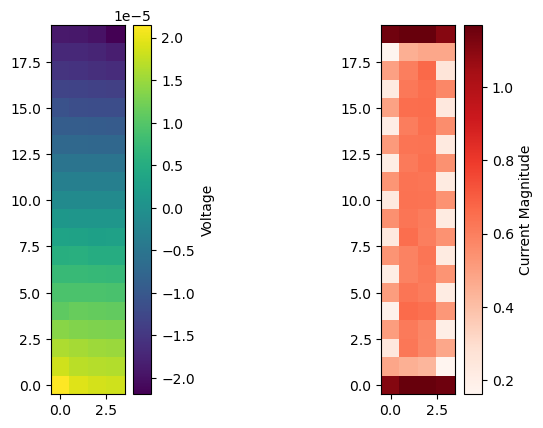

In [16]:
R_OOP, V_vec, Iabs_vec = matrix_interactions(depth=10,seed=11, std=0.0, h_frac=0.99, ext_R = 1.0001, isOOP=True, visuals=True)
print('R_OOP = ', R_OOP)
#3D visualization #https://stackoverflow.com/questions/45969974/what-is-the-most-efficient-way-to-plot-3d-array-in-python/69720369#69720369
i = 0
xlist = []
ylist = []
zlist = []
vals = []

#this while loop looks complicated, but its job is just to unpack Iabs_vec (which is just a long list) and assign 3D coordinates to each of the values. See attached picture of flake numberings
while(i<len(Iabs_vec)-2):
    Di = i%32
    if(Di%2 == 0):
        x = ((Di%8)/2)
        y = int(Di/8)
        z = 2*int(i/32)
    else:
        x = ((Di-1)%8)/2 + 0.5   #0.5 is to get the staggering effect
        y = int((Di-1)/8) +0.5
        z = 2*int(i/32)+1
    
    vals.append(Iabs_vec[i])
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)
    i+=1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
vals = np.array(vals)
a1 = ax.scatter(xlist, ylist, zlist, c=vals, s=50, cmap='Reds')
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.show()



#Extracting one vertical slice so we can visualize the system
repeat = 32   #flake numbering, 32 flakes per unit cell
V_slice = []
I_slice = []
i = 16          #change this starting value to 0,8,16, or 24 to change what vertical slice you're choosing

while(i < len(V_vec)-8):
    V_slice.append(V_vec[i:i+7:2])    #gets one row, see picture diagram. syntax is [start: stop: stepsize]
    V_slice.append(V_vec[i+1:i+8:2])
    I_slice.append(Iabs_vec[i:i+7:2])   
    I_slice.append(Iabs_vec[i+1:i+8:2])
    i+=repeat
V_slice = np.array(V_slice)
I_slice = np.array(I_slice)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.subplots_adjust(wspace=1)
a1 = ax1.imshow(V_slice, cmap='viridis', origin='lower')       #origin upper or lower to flip orientation
a2 = ax2.imshow(I_slice, cmap='Reds', origin='lower')                    #, vmin=0, vmax=0.3) adjust colorbar range

fig.colorbar(a1, ax=ax1, label='Voltage')
cbar2 = fig.colorbar(a2, ax=ax2, label='Current Magnitude')
plt.show()

# print(V_vec)
# print(Iabs_vec)


In [29]:
depths = np.arange(3,64,10)

This is an example of running the program while varying certain parameters, then plotting what prefactor c the program predicts we should see in our experiment.

In [41]:
#plotting how the prefactor changes with N, over different distributions of resistances in the network. (standard deviation, fraction of hotspots, resistances to external nodes)
#matrix_interactions(depth, std, isOOP, h_frac=0.0, ext_R = 0.001, seed=0,  visuals = False)

def prefactor_plot(Stdev, HF, ER):                            #remember the mean resistance is always R
    
    clist = []
    for i in depths:
        R_OOP=0
        R_IP=0
        #print(i)
        R_OOP += np.mean([matrix_interactions( i, Stdev,seed ,h_frac=HF, ext_R = ER, isOOP=True, visuals=False) for seed in range(50)])
        
        R_IP +=  np.mean([matrix_interactions( i, Stdev, seed,h_frac=HF, ext_R = ER, isOOP=False, visuals=False) for seed in range(50)])
    
        R_OOP=R_OOP/50     #taking averages
        R_IP=R_IP/50
        
    
        c= (R_OOP/R_IP) * (4.0/i**2)
        clist.append(c)

    return clist 
#cdefault = prefactor_plot(0.0, 0.0, 10000.0001)


In [261]:
prefactor_plot(0, 0.99, 1)

KeyboardInterrupt: 

In [139]:
import pandas as pd

In [141]:
df1 = pd.DataFrame()

In [53]:
errr= [0.0001,1,10000]

for hf in np.arange(0,0.9,0.1):
    for std in np.arange(0,0.9,0.1):
        for er in errr:
            name = f'Stdev_{std:2.2f}_HF_{hf:2.2f}_ER_{er:2.2f}'
            print(f'values started : {name}')
            list_resist = prefactor_plot(std,hf,er)
            np.savetxt(f'/home/shardul/arvind/resis_{name}.csv',list_resist,delimiter=',')
            print(f'values done : {name}')

values started : Stdev_0.00_HF_0.00_ER_0.00
values done : Stdev_0.00_HF_0.00_ER_0.00
values started : Stdev_0.00_HF_0.00_ER_1.00
values done : Stdev_0.00_HF_0.00_ER_1.00
values started : Stdev_0.00_HF_0.00_ER_10000.00
values done : Stdev_0.00_HF_0.00_ER_10000.00
values started : Stdev_0.10_HF_0.00_ER_0.00
values done : Stdev_0.10_HF_0.00_ER_0.00
values started : Stdev_0.10_HF_0.00_ER_1.00
values done : Stdev_0.10_HF_0.00_ER_1.00
values started : Stdev_0.10_HF_0.00_ER_10000.00
values done : Stdev_0.10_HF_0.00_ER_10000.00
values started : Stdev_0.20_HF_0.00_ER_0.00
values done : Stdev_0.20_HF_0.00_ER_0.00
values started : Stdev_0.20_HF_0.00_ER_1.00
values done : Stdev_0.20_HF_0.00_ER_1.00
values started : Stdev_0.20_HF_0.00_ER_10000.00
values done : Stdev_0.20_HF_0.00_ER_10000.00
values started : Stdev_0.30_HF_0.00_ER_0.00
values done : Stdev_0.30_HF_0.00_ER_0.00
values started : Stdev_0.30_HF_0.00_ER_1.00
values done : Stdev_0.30_HF_0.00_ER_1.00
values started : Stdev_0.30_HF_0.00_ER_10

In [341]:
def plot(stand,hot,res):
#    count=11
    for std in np.arange(0.1,0.9,0.1):
        data = np.loadtxt(f'/home/shardul/arvind/resis_Stdev_{std:2.2f}_HF_{0.3:2.2f}_ER_{res:2.2f}.csv',delimiter=',')
        plt.plot(depths,data,label=f'std :{std:2.1f}')
    plt.legend()
    #plt.xscale('log')
    plt.title(f' Mean = 1,Hotspot={hot}, Lead_resistance = {res}')
    plt.xlabel(f'# of layers')
    plt.ylabel(f'Cofactor')
#    plt.savefig(f'/home/shardul/arvind/fig_{count}.pdf')
    plt.show()
#    count+=1

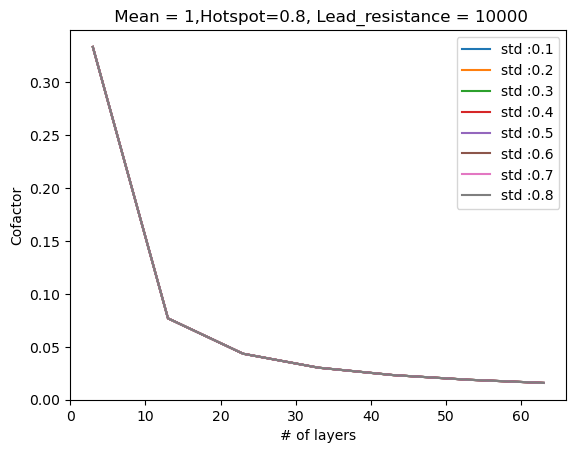

In [347]:
plot(0.1,0.8,10000)

In [337]:
np.loadtxt(f'/home/shardul/arvind/resis_Stdev_{0.2:2.2f}_HF_{0.8:2.2f}_ER_{1:2.2f}.csv',delimiter=',')

array([0.33313256, 0.07714944, 0.04382921, 0.03046314, 0.02348703,
       0.01906623, 0.01605628])

In [353]:
np.loadtxt(f'/home/shardul/arvind/resis_Stdev_{0.8:2.2f}_HF_{0.8:2.2f}_ER_{10000:2.2f}.csv',delimiter=',')

array([0.33340257, 0.07688987, 0.0434559 , 0.03028642, 0.02324268,
       0.01885705, 0.01586376])

In [145]:
errr= [0.0001,1,10000]
data_dict = {}
for hf in np.arange(0,0.9,0.1):
    for std in np.arange(0,0.9,0.1):
        for er in errr:
            name = f'Stdev_{std:2.2f}_HF_{hf:2.2f}_ER_{er:2.2f}'
            impdata = np.loadtxt(f'/home/shardul/arvind/resis_Stdev_{std:2.2f}_HF_{hf:2.2f}_ER_{er:2.2f}.csv',delimiter=',')
            data_dict[name] = impdata

df1 = pd.DataFrame(data_dict)

In [151]:
df1.insert(0,'# no of layers',depths)
df1.to_csv(f'/home/shardul/arvind/dataset.csv')

In [ ]:
print('running...')
c1 = prefactor_plot(0.9, 0.0, 0.0001)
c2 = prefactor_plot(0.9, 0.1, 0.0001)
print('almost...')
c3 = prefactor_plot(0.9, 0.6, 0.0001)

plt.scatter(depths, cdefault, label='All resistances 1')
plt.scatter(depths, c1, label='Std=0.9')
plt.scatter(depths, c2, label='Std=0.9, 1/10 are hotspots')
plt.scatter(depths, c3, label='Std = 0.9, 3/10 are hotspots')

plt.xlabel('Depth')
plt.ylabel('Prefactor c')
plt.legend()
plt.show()

The code from my presentation to see how the program compares to our theoretical model of counting channels and resistors per channel.

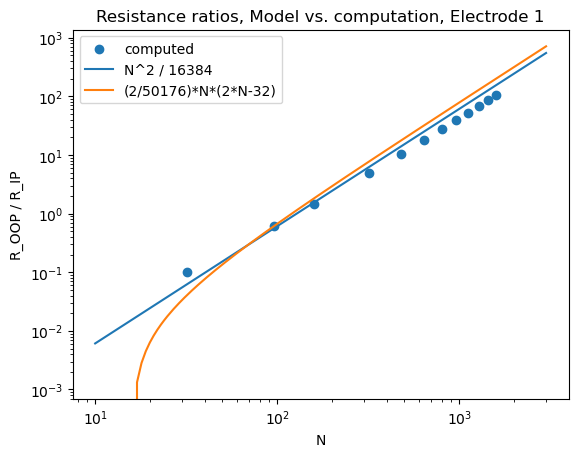

In [38]:
#testing the ratio of R_OOP/R_IP
depths = [1,3,5,10,15,20,25,30,35,40, 45, 50]
Stdev = 0.0
rlist = []
xvals = []

for i in depths: 
    R_OOP = matrix_interactions(seed=1, depth=i, std=Stdev,ext_R = 1.0, isOOP=True, visuals=False)
    R_IP =  matrix_interactions(seed=1, depth=i, std=Stdev,ext_R = 1.0, isOOP=False, visuals=False) 
    ratio= (R_OOP/R_IP)
    rlist.append(ratio)
    xvals.append(32*i)

plt.scatter(xvals, rlist, label = 'computed')
N = np.linspace(10, 3000, 3000)

fity = N**2 /16384
plt.plot(N,fity, label = 'N^2 / 16384')

fity2 = (2/50176)*N*(2*N-32)
plt.plot(N,fity2, label = '(2/50176)*N*(2*N-32)')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('R_OOP / R_IP')
plt.title('Resistance ratios, Model vs. computation, Electrode 1')
plt.legend()
plt.savefig(f'/home/shardul/arvind/model_resis_1.pdf')
plt.show()


## Guide to run this Notebook
The first 5 cells up to matrix_interactions define the program, and they don't have to be changed for simply running the program. They do have to be run when starting a new session. 

To do calculations, call matrix_interactions(depth, std, isOOP, h_frac, ext_R, seed, visuals), editing any of these arguments. It will output a net resistance. Then you can use the outputs of Iabs_vec and V_vec (if you set visuals=True) to visualize the results if you'd like. Set visuals=False if you want to run multiple trials all at once.

I've also set up some templates in the last two cells for easy ways to run the program over many different parameters.


## Additional notes:


A minor tweak I made from Shardul's original code was I got rid of anything that said, “if > G_2dmax” in the create_3d_graph method. This caused one connection with the corner flake to be skipped, but overall has little impact.

The subtracting a small number of the diagonal is an approximation to avoid having a singular matrix. I've noticed some possible conservation of current issues (current magnitude seems to drop in the middle layers) but this can be avoided as long as this approximate number is small enough (Shardul recommended it be at least as small as -0.000001). Changing this number can significantly change the results, so keep this in mind.

On that note, changing some of the parameters slightly can change the results for the prefactor c significantly. Especially ext_R, the results agree well with our theoretical model from counting channels and resistors per channel only if ext_R is set to a negligible value. This won't be true for ext_R being comparable to 1, but in these cases the prefactor c asymptotes more like our experiments.

At the moment this code only works with the 4x4 base, this could be generalized in the future.


In [ ]:
#Test code snippets

#some test code for playing with the invertibility approxiation

#trying something to solve current being lost in the center
# half1 = int(adjM.shape[0] / 2)
# half2 = adjM.shape[0] - half1
# offsets = np.concatenate((np.ones(half1), np.ones(half2)*-1))
# np.random.shuffle(offsets)

    
#alt_offsets = np.array([(-1)**i * 0.0001 for i in range(adjM.shape[0])])     #Create the alternating pattern of -0.0001 and +0.0001